In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply

from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Model

In [5]:
### Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [6, 6, 10, 5],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None},
        #  {'name': 'mu1', 'type': 'normfactor', 'data': None}
        ]},

    {'name': 'background',
     'data': [450, 550, 650, 650]
     ,
     'modifiers': [
        ## Staterror / Normal
        # {"name": "my_staterror","type": "staterror","data": [100.0, 200.0, 200.0, 200.0],},
        ## Lumi / Normal
        # {'name': 'lumi', 'type': 'lumi', 'data': None},
        ## Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [652, 662, 702, 702], 'lo_data': [650, 660, 700, 700]}},
        # ## Uncorrelated / Poisson
        # {'name': 'uncorr_bkg', 'type': 'shapesys','data': [7, 8, 7.17, 7.17]},
        
         ]
         },    
                                 
    ]},
    ]
    ,
    "parameters": [
            {
                "name": "lumi",
                "auxdata": [1.0],
                "sigmas": [0.017],
                "bounds": [[0.915, 1.085]],
                "inits": [1.0],
            }],
        }
)

obs = model.expected_actualdata(model.config.suggested_init())

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_dict = {}
unconstr_dict = {
    'uncon0': {'type': 'unconstrained', 'type2': 'normal', 'input': [[2.], [1.]]},
    # 'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[2], [1]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)


    # dictionary with keys 'model', 'obs', 'priors', 'precision'
precision = []
[precision.append(float(obs[i])**(0.5)) for i in range(nBins)]
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=precision, priors=prior_dict)

In [2]:
# with open('SRee_SRmm_Srem.json') as serialized:
with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()

obs = workspace.data(model, include_auxdata=False)

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[2.], [1.]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)

    # dictionary with keys 'model', 'obs', 'priors', 'precision'
precision = []
[precision.append(float(obs[i])**(0.5)) for i in range(nBins)]
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=precision, priors=prior_dict)

NameError: name 'json' is not defined

## General functions

In [2]:
# Jax expected data
@jax.jit
def processed_expData(parameters):
    return model.expected_actualdata(parameters)

jitted_processed_expData = jax.jit(processed_expData)

# Gradient list (dn_bins/dx_1, ..., dn_bins/dx_nPars)
@jax.jit
def vjp_expData(pars, tang_vec):
    _, back = jax.vjp(processed_expData, pars)
    return back(tang_vec)[0]

jitted_vjp_expData = jax.jit(vjp_expData)

# jitted_processed_expData = jax.jit(processed_expData)
# jitted_vjp_expData = jax.jit(vjp_expData)


## Op Class

#### Gradient Op

In [3]:
class VJPOp(Op):

    itypes = [pt.dvector,pt.dvector]  
    otypes = [pt.dvector]

    def perform(self, node, inputs, outputs):
        (parameters, tangent_vector) = inputs
        results = jitted_vjp_expData(parameters, tangent_vector)

        # if not isinstance(results, (list, tuple)):
        #         results = (results,)
                
        # for i, r in enumerate(results):
        #     outputs[i][0] = np.asarray(r)
        outputs[0][0] = np.asarray(results)

vjp_op = VJPOp()

#### Non Gradient Op

In [4]:
class ExpDataOp(Op):

    itypes = [pt.dvector]  
    otypes = [pt.dvector]

    def perform(self, node, inputs, outputs):
        (parameters, ) = inputs
        results = jitted_processed_expData(parameters)

        # if len(outputs) == 1:
        #         outputs[0][0] = np.asarray(results)
        #         retinitn
        # for i, r in enumerate(results):
        #         outputs[i][0] = np.asarray(r)
        outputs[0][0] = np.asarray(results)

    # def grad(self, inputs, output_gradients):
    #     (parameters,) = inputs
    #     (tangent_vector,) = output_gradients
    #     retinitn [vjp_op(parameters, tangent_vector)]
        
expData_op = ExpDataOp()

## Sampling

#### Metropolis

In [ ]:
# %%timeit 
with pm.Model() as m:
    pars = pm.Deterministic('pars', prepare_inference.priors2pymc(prepared_model))
    ExpData_Det = pm.Deterministic('ExpData_Det', expData_op(pars))

    # ExpData = pm.Poisson("ExpData", mu=ExpData_Det, observed=obs)
    ExpData = pm.Normal("ExpData", mu=ExpData_Det, sigma = precision, observed=obs)
    
    step1 = pm.Metropolis()
    # step2 = pm.NUTS()
    # step3 = pm.HamiltonianMC()
    
    post_data = pm.sample(draws=1000, chains = 1, cores=4, step=step1, progressbar=True)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(100)

#### NUTS

In [7]:
# %%timeit
with pm.Model() as m1:
    pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
    ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))

    # ExpData1 = pm.Poisson("ExpData1", mu=ExpData_Det1, observed=obs)
    ExpData1 = pm.Normal("ExpData1", mu=ExpData_Det1, sigma = precision, observed=obs)


    post_data = pm.sample(100, chains=1, cores=4, init='advi')
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 51700
Interrupted at 51,699 [25%]: Average Loss = 1.3236e+06
Interrupted at 51,699 [25%]: Average Loss = 1.3236e+06


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 453 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


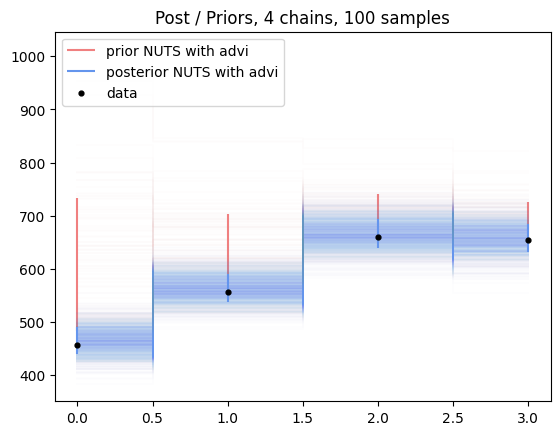

In [10]:
# Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.ExpData[0].T, alpha = 0.01, c = 'lightcoral', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'lightcoral', label='prior NUTS with advi');

# plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.ExpData[0].T, alpha = 0.01, c = 'gold', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'gold', label='prior Metropolis');

# Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='posterior NUTS with advi')

# plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'mediumpinitple', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'mediumpinitple', label='posterior Metropolis')


# Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Post / Priors, 4 chains, 100 samples')

# plt.savefig('Metropolis_adviNUsS_ttbar')
plt.show()

In [ ]:
az.plot_trace(prior_pred.prior, var_names='Unconstrained')
az.plot_trace(post_data.posterior, var_names='Unconstrained')

az.plot_trace(prior_pred.prior, var_names='Normals')
az.plot_trace(post_data.posterior, var_names='Normals')

In [ ]:
az.plot_trace(prior_pred.prior, var_names='Unconstrained')
az.plot_trace(post_data.posterior, var_names='Unconstrained')

az.plot_trace(prior_pred.prior, var_names='Normals')
az.plot_trace(post_data.posterior, var_names='Normals')

In [ ]:
fig = corner.corner(prior_pred.prior.Normals[0], hist_kwargs={'density': True}, color='green');
fig = corner.corner(post_data.posterior.Normals[0], fig = fig, color = 'steelblue', hist_kwargs={'density': True});

## Convergence check posterior for the predictions

In [19]:
N = 5
nBins = N
init_obs = jnp.array([70., 70., 90., 90., 80.])
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N, [45]*N, [55]*N)
model.expected_actualdata(model.config.suggested_init()),model.config.suggested_init()

n_samples = 1000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=init_obs, precision=8, priors=prior_dict)

#### First inference

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
INFO:pymc:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
INFO:pymc:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]
INFO:pymc:Sampling: [ExpData1, Normals, Unconstrained]


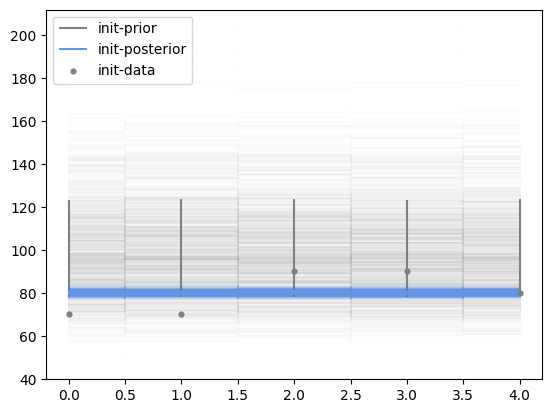

In [23]:
# init prior and posteriors
with pm.Model() as m1:
    # pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
    pars1 = prepare_inference.priors2pymc(prepared_model)
    # ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))

    ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 1, observed=init_obs)
    
    step1 = pm.Metropolis()
    
    post_data_init = pm.sample(n_samples, chains=1, cores=4, init='advi')
    post_pred_init = pm.sample_posterior_predictive(post_data_init)
    prior_pred_init = pm.sample_prior_predictive(n_samples)

# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'grey', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'grey', label='init-prior');

# init Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred_init.posterior_predictive.ExpData1[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_init.posterior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='init-posterior')

# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")


plt.legend(loc='upper left')

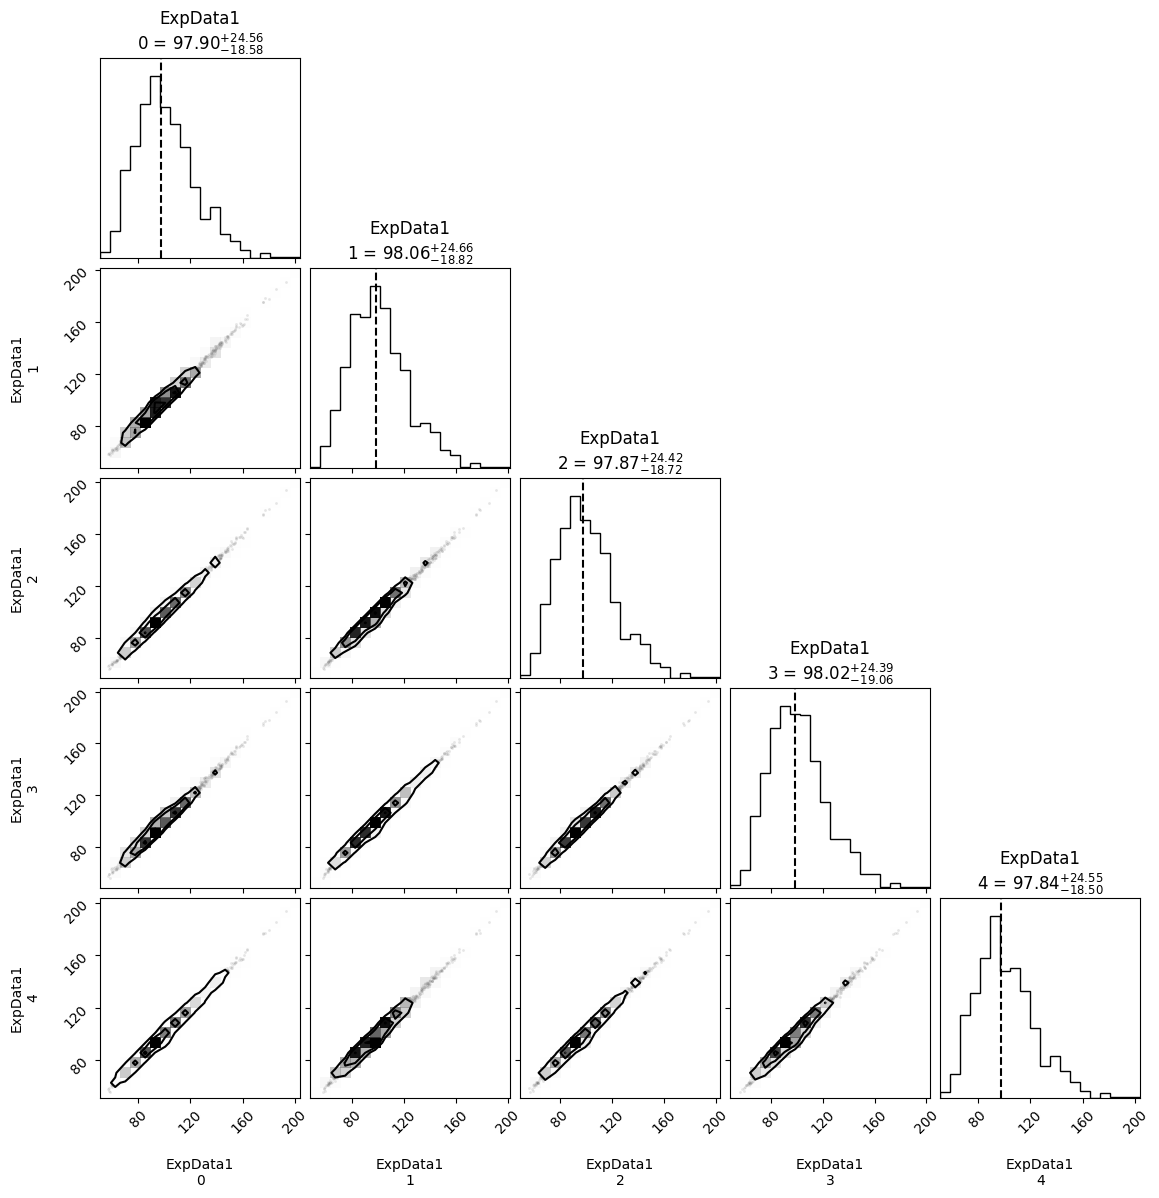

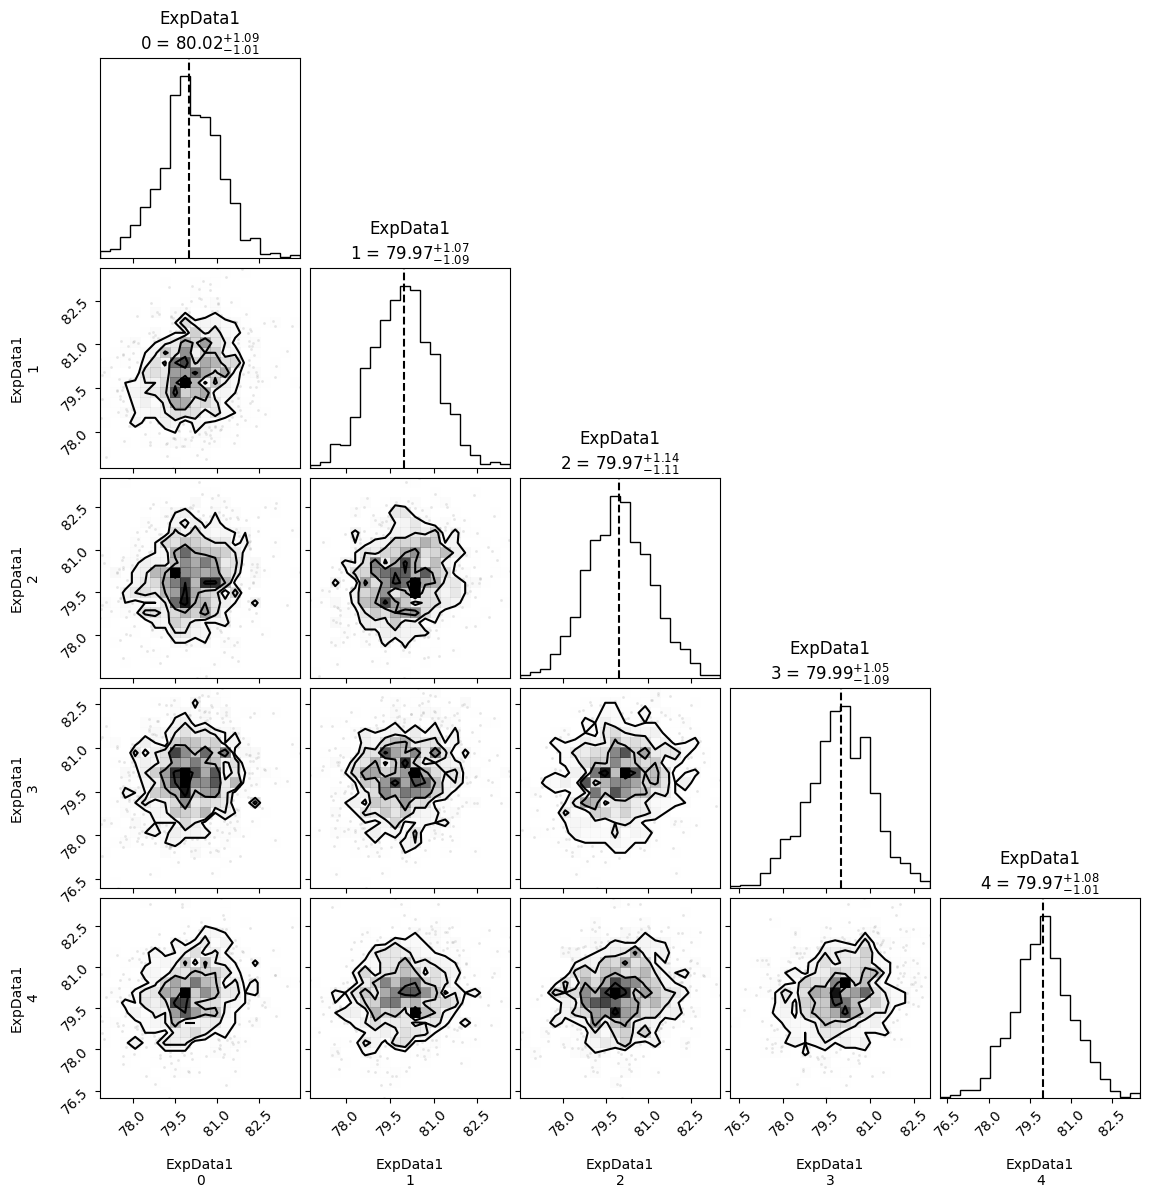

In [24]:
a = corner.corner(prior_pred_init.prior_predictive, quantiles=[0.5], show_titles=True)
b = corner.corner(post_pred_init.posterior_predictive, quantiles=[0.5], show_titles=True)

#### Iterative inference

In [ ]:
obs_from_prior = init_obs

n_samples = 100
n_iterations = 2

post = []
post_average_iters = []

for iterations in np.linspace(1, 15, n_iterations, dtype=int):
    obs_from_prior = init_obs
    print(f'ITERATION: {iterations}')
    for i in range(iterations):
        with pm.Model() as m1:
            # pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
            pars1 = prepare_inference.priors2pymc(prepared_model)
            
            # ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))
            ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 8, observed=obs_from_prior)
            
            step1 = pm.Metropolis()
            
            post_data = pm.sample(n_samples, chains=1, cores=4, step=step1)
            post_pred = pm.sample_posterior_predictive(post_data)
            prior_pred = pm.sample_prior_predictive(n_samples)

            post.append(post_pred.posterior_predictive.ExpData1[0])

            ii = randint(0, n_samples - 1)
            print(f'ii: {ii} for i: {i}')
            obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 
        
    post_average = []
    for i in range(nBins):
        aa = 0
        for b in range(n_samples):
            for a in range(iterations):
                aa = aa + post[a][b][i]
        post_average.append(aa/(n_samples*iterations))

    post_average_iters.append(np.asarray(post_average))


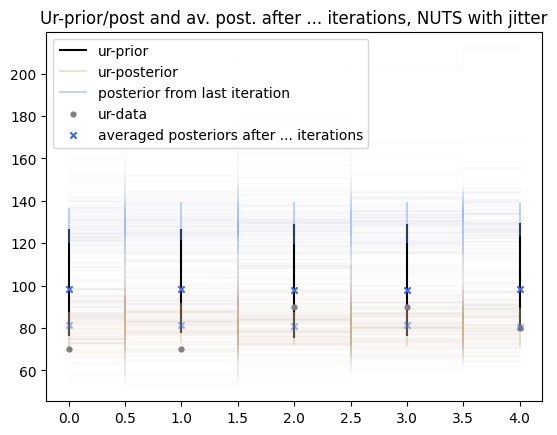

In [115]:
# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'black', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'black', label='init-prior');

# init Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred_init.posterior_predictive.ExpData1[0].T, alpha = 0.02, c = 'tan', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_init.posterior_predictive.ExpData1[0],[.15,.85],axis=0), alpha = 0.4, colors = 'tan', label='init-posterior')

# Posterior from last iteration
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.ExpData1[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.ExpData1[0],[.15,.85],axis=0),colors = 'cornflowerblue', alpha=0.4, label='posterior from last iteration')

# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")

# Average posterior
plt.scatter(np.arange(nBins), post_average_iters[n_iterations-1], c = 'royalblue', s=20, marker='x', zorder = 999, alpha = 1, label = 'averaged posteriors after ... iterations')
for i in range(n_iterations-1):
    plt.scatter(np.arange(nBins), post_average_iters[i], c = 'royalblue', s=20, marker='x', zorder = 999, alpha = i/1000+0.5)

plt.legend(loc='upper left')
plt.title(f'init-prior/post and av. post. after ... iterations, NUTS with jitter')

# plt.savefig('Metropolis_1_and_100_iterations.pdf')
plt.show()

## Convergence check posterior with Corner Plots

In [11]:
N = 3
nBins = N
init_obs = jnp.array([70., 60., 60.])# 90., 90., 80.])
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N, [45]*N, [55]*N)
model.expected_actualdata(model.config.suggested_init()),model.config.suggested_init()

n_samples = 1000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5000.], [1000.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=init_obs, precision=4, priors=prior_dict)

#### init inference

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


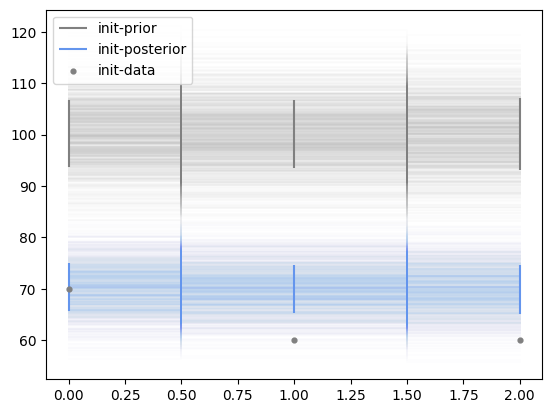

In [12]:
# init prior and posteriors
with pm.Model() as m1:
    # pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
    pars1 = prepare_inference.priors2pymc(prepared_model)
    # ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))

    ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=init_obs)
    
    step1 = pm.Metropolis()
    
    post_data_init = pm.sample(n_samples, chains=1, cores=4, init='advi')
    post_pred_init = pm.sample_posterior_predictive(post_data_init)
    prior_pred_init = pm.sample_prior_predictive(n_samples)

# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'grey', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'grey', label='init-prior');

# init Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred_init.posterior_predictive.ExpData1[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_init.posterior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='init-posterior')

# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")


plt.legend(loc='upper left')

In [ ]:
a = corner.corner(prior_pred_init.prior, quantiles=[0.5], show_titles=True)
b = corner.corner(post_data_init.posterior, quantiles=[0.5], show_titles=True)

In [ ]:
a = corner.corner(prior_pred_init.prior_predictive, quantiles=[0.5], show_titles=True)
b = corner.corner(post_pred_init.posterior_predictive, quantiles=[0.5], show_titles=True)

#### Iterative inference with averaging

In [ ]:
obs_from_prior = init_obs

n_samples = 100
n_iterations = 3

post = []
post_average_iters = []

for iterations in np.linspace(1, 15, n_iterations, dtype=int):
    obs_from_prior = init_obs
    print(f'ITERATION: {iterations}')
    for i in range(iterations):
        with pm.Model() as m1:
            # pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
            pars1 = prepare_inference.priors2pymc(prepared_model)
            
            # ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))
            ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 8, observed=obs_from_prior)
            
            step1 = pm.Metropolis()
            
            post_data = pm.sample(n_samples, chains=1, cores=4)#, step=step1)
            post_pred = pm.sample_posterior_predictive(post_data)
            prior_pred = pm.sample_prior_predictive(n_samples)

            post.append(post_pred.posterior_predictive.ExpData1[0])

            ii = randint(0, n_samples - 1)
            print(f'ii: {ii} for i: {i}')
            obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 
        
    post_average = []
    for i in range(nBins):
        aa = 0
        for b in range(n_samples):
            for a in range(iterations):
                aa = aa + post[a][b][i]
        post_average.append(aa/(n_samples*iterations))

    post_average_iters.append(np.asarray(post_average))


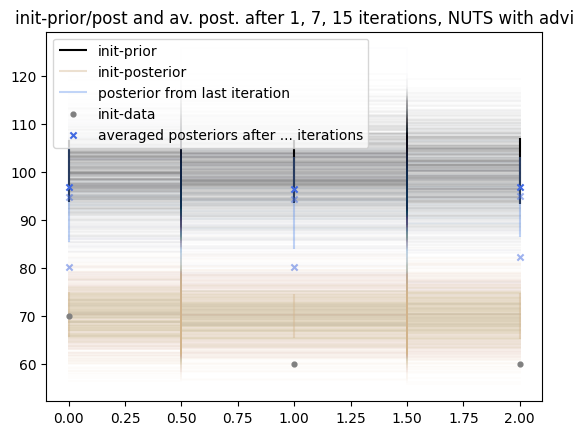

In [21]:
# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'black', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'black', label='init-prior');

# init Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred_init.posterior_predictive.ExpData1[0].T, alpha = 0.02, c = 'tan', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_init.posterior_predictive.ExpData1[0],[.15,.85],axis=0), alpha = 0.4, colors = 'tan', label='init-posterior')

# Posterior from last iteration
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.ExpData1[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.ExpData1[0],[.15,.85],axis=0),colors = 'cornflowerblue', alpha=0.4, label='posterior from last iteration')

# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")

# Average posterior
plt.scatter(np.arange(nBins), post_average_iters[n_iterations-1], c = 'royalblue', s=20, marker='x', zorder = 999, alpha = 1, label = 'averaged posteriors after ... iterations')
for i in range(n_iterations-1):
    plt.scatter(np.arange(nBins), post_average_iters[i], c = 'royalblue', s=20, marker='x', zorder = 999, alpha = i/1000+0.5)

plt.legend(loc='upper left')
plt.title(f'init-prior/post and av. post. after 1, 7, 15 iterations, NUTS with advi')

# plt.savefig('Metropolis_1_and_100_iterations.pdf')
plt.show()

#### Iterative inference without averaging

In [79]:
obs_from_prior = init_obs
iterations = 2
post = []

for i in range(iterations):
    with pm.Model() as m1:
        pars1 = prepare_inference.priors2pymc(prepared_model)

        ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=obs_from_prior)
        
        step1 = pm.Metropolis()
        
        post_data_2 = pm.sample(n_samples, chains=1, cores=4, step=step1)
        post_pred_2 = pm.sample_posterior_predictive(post_data_2)
        prior_pred_2 = pm.sample_prior_predictive(n_samples)

        post.append(post_pred.posterior_predictive.ExpData1[0])

        ii = randint(0, n_samples - 1)
        print(f'ii: {ii} for i: {i}')
        obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 

Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 84 for i: 0


Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 70 for i: 1


In [62]:
post_pred_1.posterior_predictive.ExpData1[0][20][2]

<xarray.DataArray 'ExpData1' ()>
array(72.78872109)
Coordinates:
    chain           int64 0
    draw            int64 20
    ExpData1_dim_2  int64 2

In [80]:
post_average_1 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_1.posterior_predictive.ExpData1[0][ii][i]
    post_average_1.append(aa/n_samples)

post_average_2 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_2.posterior_predictive.ExpData1[0][ii][i]
    post_average_2.append(aa/n_samples)


post_average_3 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_3.posterior_predictive.ExpData1[0][ii][i]
    post_average_3.append(aa/n_samples)

post_average_10 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_10.posterior_predictive.ExpData1[0][ii][i]
    post_average_10.append(aa/n_samples)


post_average_15 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_15.posterior_predictive.ExpData1[0][ii][i]
    post_average_15.append(aa/n_samples)

post_average_20 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_20.posterior_predictive.ExpData1[0][ii][i]
    post_average_20.append(aa/n_samples)

print(np.asarray(post_average_1))
print(np.asarray(post_average_3))
print(np.asarray(post_average_10))
print(np.asarray(post_average_15))
print(np.asarray(post_average_20))


[69.8469248  69.1369342  70.08143783]
[104.4381264  104.46526213 104.20142341]
[92.87185935 93.26483835 92.30213925]
[103.9924047  103.00087175 103.69225158]
[101.56137804 101.69948907 101.65237718]


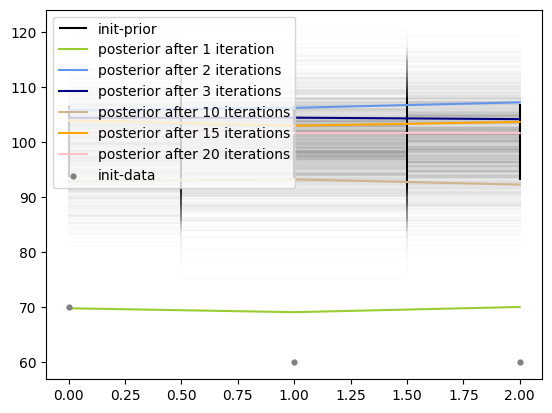

In [87]:

# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'black', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'black', label='init-prior');

# iiterative Prior
# plt.step(np.linspace(0,nBins-1,nBins),prior_pred_1.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'green', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(prior_pred_1.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'green', label='prior after 1 iteration');

plt.plot(np.arange(nBins), post_average_1, color = 'yellowgreen', label='posterior after 1 iteration')
plt.plot(np.arange(nBins), post_average_2, color = 'cornflowerblue', label='posterior after 2 iterations')
plt.plot(np.arange(nBins), post_average_3, color = 'navy', label='posterior after 3 iterations')
plt.plot(np.arange(nBins), post_average_10, color = 'tan', label='posterior after 10 iterations')
plt.plot(np.arange(nBins), post_average_15, color = 'orange', label='posterior after 15 iterations')
plt.plot(np.arange(nBins), post_average_20, color = 'pink', label='posterior after 20 iterations')


# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")


plt.legend(loc='upper left')

#### Convergence Checks with a large gap between prior and initial posterior

In [88]:
N = 3
nBins = N
init_obs = jnp.array([700., 600., 600.])# 90., 90., 80.])
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N, [45]*N, [55]*N)
model.expected_actualdata(model.config.suggested_init()),model.config.suggested_init()

n_samples = 1000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5000.], [1000.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=init_obs, precision=4, priors=prior_dict)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


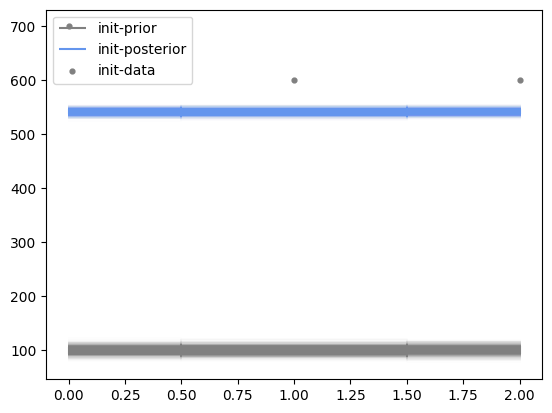

In [89]:
# init prior and posteriors
with pm.Model() as m1:
    # pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
    pars1 = prepare_inference.priors2pymc(prepared_model)
    # ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))

    ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=init_obs)
    
    step1 = pm.Metropolis()
    
    post_data_init = pm.sample(n_samples, chains=1, cores=4, init='advi')
    post_pred_init = pm.sample_posterior_predictive(post_data_init)
    prior_pred_init = pm.sample_prior_predictive(n_samples)

# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'grey', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'grey', label='init-prior');

# init Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred_init.posterior_predictive.ExpData1[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_init.posterior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='init-posterior')

# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")


plt.legend(loc='upper left')

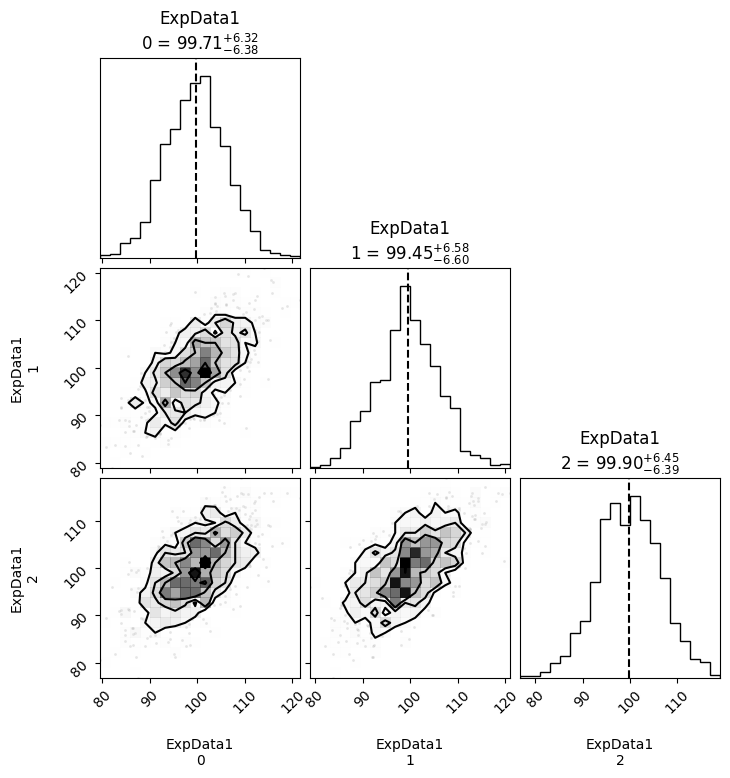

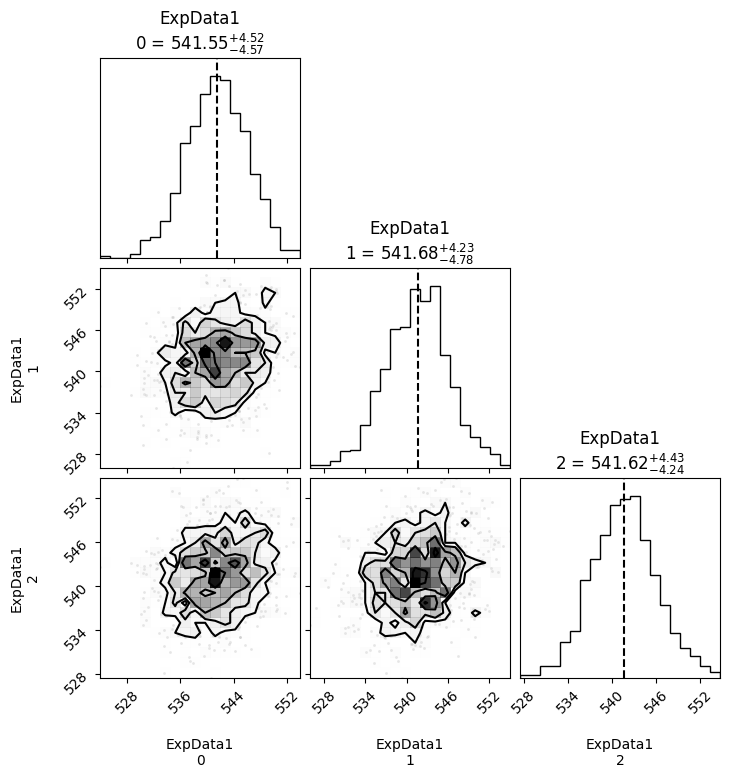

In [90]:
a = corner.corner(prior_pred_init.prior_predictive, quantiles=[0.5], show_titles=True)
b = corner.corner(post_pred_init.posterior_predictive, quantiles=[0.5], show_titles=True)

#### Iterations with averaging

In [ ]:
obs_from_prior = init_obs

n_samples = 100
n_iterations = 3

post = []
post_average_iters = []

for iterations in np.linspace(1, 25, n_iterations, dtype=int):
    obs_from_prior = init_obs
    print(f'ITERATION: {iterations}')
    for i in range(iterations):
        with pm.Model() as m1:
            # pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
            pars1 = prepare_inference.priors2pymc(prepared_model)
            
            # ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))
            ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 8, observed=obs_from_prior)
            
            step1 = pm.Metropolis()
            
            post_data = pm.sample(n_samples, chains=1, cores=4)#, step=step1)
            post_pred = pm.sample_posterior_predictive(post_data)
            prior_pred = pm.sample_prior_predictive(n_samples)

            post.append(post_pred.posterior_predictive.ExpData1[0])

            ii = randint(0, n_samples - 1)
            print(f'ii: {ii} for i: {i}')
            obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 
        
    post_average = []
    for i in range(nBins):
        aa = 0
        for b in range(n_samples):
            for a in range(iterations):
                aa = aa + post[a][b][i]
        post_average.append(aa/(n_samples*iterations))

    post_average_iters.append(np.asarray(post_average))

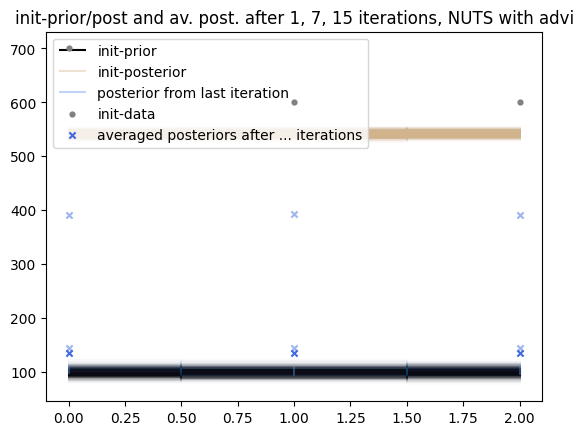

In [96]:
# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'black', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'black', label='init-prior');

# init Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred_init.posterior_predictive.ExpData1[0].T, alpha = 0.02, c = 'tan', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_init.posterior_predictive.ExpData1[0],[.15,.85],axis=0), alpha = 0.4, colors = 'tan', label='init-posterior')

# Posterior from last iteration
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.ExpData1[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.ExpData1[0],[.15,.85],axis=0),colors = 'cornflowerblue', alpha=0.4, label='posterior from last iteration')

# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")

# Average posterior
plt.scatter(np.arange(nBins), post_average_iters[n_iterations-1], c = 'royalblue', s=20, marker='x', zorder = 999, alpha = 1, label = 'averaged posteriors after ... iterations')
for i in range(n_iterations-1):
    plt.scatter(np.arange(nBins), post_average_iters[i], c = 'royalblue', s=20, marker='x', zorder = 999, alpha = i/1000+0.5)

plt.legend(loc='upper left')
plt.title(f'init-prior/post and av. post. after 1, 7, 15 iterations, NUTS with advi')

# plt.savefig('Metropolis_1_and_100_iterations.pdf')
plt.show()

#### Iterations w/o averaging

In [97]:
obs_from_prior = init_obs
iterations = 1
post = []

for i in range(iterations):
    with pm.Model() as m1:
        pars1 = prepare_inference.priors2pymc(prepared_model)

        ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=obs_from_prior)
        
        step1 = pm.Metropolis()
        
        post_data_1 = pm.sample(n_samples, chains=1, cores=4, step=step1)
        post_pred_1 = pm.sample_posterior_predictive(post_data_1)
        prior_pred_1 = pm.sample_prior_predictive(n_samples)

        ii = randint(0, n_samples - 1)
        print(f'ii: {ii} for i: {i}')
        obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 

Only 100 samples in chain.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 68 for i: 0


In [98]:
obs_from_prior = init_obs
iterations = 2
post = []

for i in range(iterations):
    with pm.Model() as m1:
        pars1 = prepare_inference.priors2pymc(prepared_model)

        ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=obs_from_prior)
        
        step1 = pm.Metropolis()
        
        post_data_2 = pm.sample(n_samples, chains=1, cores=4, step=step1)
        post_pred_2 = pm.sample_posterior_predictive(post_data_2)
        prior_pred_2 = pm.sample_prior_predictive(n_samples)

        post.append(post_pred.posterior_predictive.ExpData1[0])

        ii = randint(0, n_samples - 1)
        print(f'ii: {ii} for i: {i}')
        obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 

Only 100 samples in chain.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 15 for i: 0


Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 55 for i: 1


In [99]:
obs_from_prior = init_obs
iterations = 3
post = []

for i in range(iterations):
    with pm.Model() as m1:
        pars1 = prepare_inference.priors2pymc(prepared_model)

        ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=obs_from_prior)
        
        step1 = pm.Metropolis()
        
        post_data_3 = pm.sample(n_samples, chains=1, cores=4, step=step1)
        post_pred_3 = pm.sample_posterior_predictive(post_data_3)
        prior_pred_3 = pm.sample_prior_predictive(n_samples)


        ii = randint(0, n_samples - 1)
        print(f'ii: {ii} for i: {i}')
        obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 

Only 100 samples in chain.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 2 for i: 0


Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 28 for i: 1


Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


ii: 68 for i: 2


In [ ]:
obs_from_prior = init_obs
iterations = 10
post = []

for i in range(iterations):
    with pm.Model() as m1:
        pars1 = prepare_inference.priors2pymc(prepared_model)

        ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=obs_from_prior)
        
        step1 = pm.Metropolis()
        
        post_data_10 = pm.sample(n_samples, chains=1, cores=4, step=step1)
        post_pred_10 = pm.sample_posterior_predictive(post_data_10)
        prior_pred_10 = pm.sample_prior_predictive(n_samples)


        ii = randint(0, n_samples - 1)
        print(f'ii: {ii} for i: {i}')
        obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 

In [ ]:
obs_from_prior = init_obs
iterations = 15
post = []

for i in range(iterations):
    with pm.Model() as m1:
        pars1 = prepare_inference.priors2pymc(prepared_model)

        ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=obs_from_prior)
        
        step1 = pm.Metropolis()
        
        post_data_15 = pm.sample(n_samples, chains=1, cores=4, step=step1)
        post_pred_15 = pm.sample_posterior_predictive(post_data_15)
        prior_pred_15 = pm.sample_prior_predictive(n_samples)


        ii = randint(0, n_samples - 1)
        print(f'ii: {ii} for i: {i}')
        obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 

In [101]:
post_average_1 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_1.posterior_predictive.ExpData1[0][ii][i]
    post_average_1.append(aa/n_samples)

post_average_2 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_2.posterior_predictive.ExpData1[0][ii][i]
    post_average_2.append(aa/n_samples)


post_average_3 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_3.posterior_predictive.ExpData1[0][ii][i]
    post_average_3.append(aa/n_samples)

post_average_10 = []
aa = 0
for i in range(nBins):
    aa = 0
    for ii in range(n_samples):
        # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
        aa = aa + post_pred_10.posterior_predictive.ExpData1[0][ii][i]
    post_average_10.append(aa/n_samples)


# post_average_15 = []
# aa = 0
# for i in range(nBins):
#     aa = 0
#     for ii in range(n_samples):
#         # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
#         aa = aa + post_pred_15.posterior_predictive.ExpData1[0][ii][i]
    # post_average_15.append(aa/n_samples)

# post_average_20 = []
# aa = 0
# for i in range(nBins):
#     aa = 0
#     for ii in range(n_samples):
#         # print(post_pred_1.posterior_predictive.ExpData1[0][ii][i])
#         aa = aa + post_pred_20.posterior_predictive.ExpData1[0][ii][i]
#     post_average_20.append(aa/n_samples)

print(np.asarray(post_average_1))
print(np.asarray(post_average_3))
print(np.asarray(post_average_10))
# print(np.asarray(post_average_15))
# print(np.asarray(post_average_20))

[541.68272278 541.18356818 540.55596089]
[112.60568994 111.61163179 111.42571886]
[97.68704758 97.6331254  97.18823551]


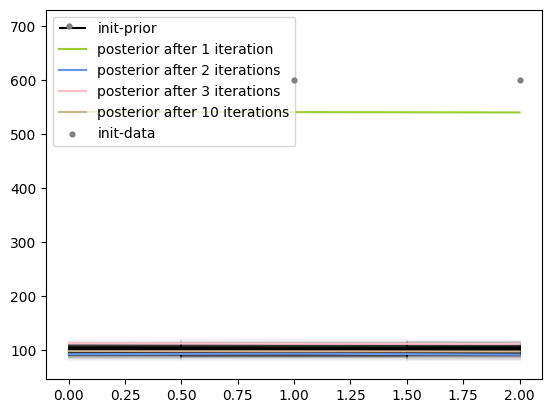

In [103]:
# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'black', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'black', label='init-prior');

# iiterative Prior
# plt.step(np.linspace(0,nBins-1,nBins),prior_pred_1.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'green', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(prior_pred_1.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'green', label='prior after 1 iteration');

plt.plot(np.arange(nBins), post_average_1, color = 'yellowgreen', label='posterior after 1 iteration')
plt.plot(np.arange(nBins), post_average_2, color = 'cornflowerblue', label='posterior after 2 iterations')
plt.plot(np.arange(nBins), post_average_3, color = 'pink', label='posterior after 3 iterations')
plt.plot(np.arange(nBins), post_average_10, color = 'tan', label='posterior after 10 iterations')
# plt.plot(np.arange(nBins), post_average_15, color = 'orange', label='posterior after 15 iterations')
# plt.plot(np.arange(nBins), post_average_20, color = 'pink', label='posterior after 20 iterations')


# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")


plt.legend(loc='upper left')

## Changing the priors

In [104]:
N = 3
nBins = N
init_obs = jnp.array([70., 60., 60.])# 90., 90., 80.])
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N, [45]*N, [55]*N)
model.expected_actualdata(model.config.suggested_init()),model.config.suggested_init()

n_samples = 1000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5000.], [1000.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=init_obs, precision=4, priors=prior_dict)

In [ ]:
obs_from_prior = init_obs
iterations = 10
post = []

for i in range(iterations):
    with pm.Model() as m1:
        pars1 = prepare_inference.priors2pymc(prepared_model)

        ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=obs_from_prior)
        
        step1 = pm.Metropolis()
        
        post_data_10 = pm.sample(n_samples, chains=1, cores=4, step=step1)
        post_pred_10 = pm.sample_posterior_predictive(post_data_10)
        prior_pred_10 = pm.sample_prior_predictive(n_samples)


        ii = randint(0, n_samples - 1)
        print(f'ii: {ii} for i: {i}')
        obs_from_prior = prior_pred.prior_predictive.ExpData1[0][ii] 

# Autocorrelation

In [128]:
N = 3
nBins = N
init_obs = jnp.array([70., 60., 60.])# 90., 90., 80.])
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N, [45]*N, [55]*N)
model.expected_actualdata(model.config.suggested_init()),model.config.suggested_init()

n_samples = 10_000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5000.], [1000.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=init_obs, precision=4, priors=prior_dict)

#### NUTS advi

In [142]:
n_samples = 1000

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


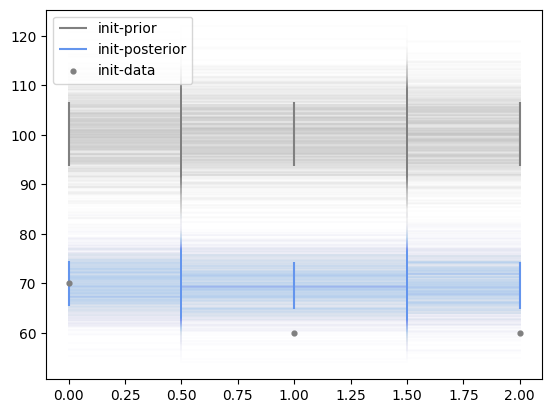

In [143]:
# init prior and posteriors
with pm.Model() as m1:
    # pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
    pars1 = prepare_inference.priors2pymc(prepared_model)
    # ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))

    ExpData1 = pm.Normal("ExpData1", mu=expData_op(pars1), sigma = 4, observed=init_obs)
    
    step1 = pm.Metropolis()
    
    post_data_init = pm.sample(n_samples, chains=1, cores=4)
    post_pred_init = pm.sample_posterior_predictive(post_data_init)
    prior_pred_init = pm.sample_prior_predictive(n_samples)

# init Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_init.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'grey', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_init.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'grey', label='init-prior');

# init Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred_init.posterior_predictive.ExpData1[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_init.posterior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='init-posterior')

# Observations
plt.scatter(np.arange(nBins), init_obs, c = 'grey', s=12, zorder = 999, label = "init-data")


plt.legend(loc='upper left')

array([[<AxesSubplot: title={'center': 'Normals'}>,
        <AxesSubplot: title={'center': 'Normals'}>],
       [<AxesSubplot: title={'center': 'Unconstrained'}>,
        <AxesSubplot: title={'center': 'Unconstrained'}>]], dtype=object)

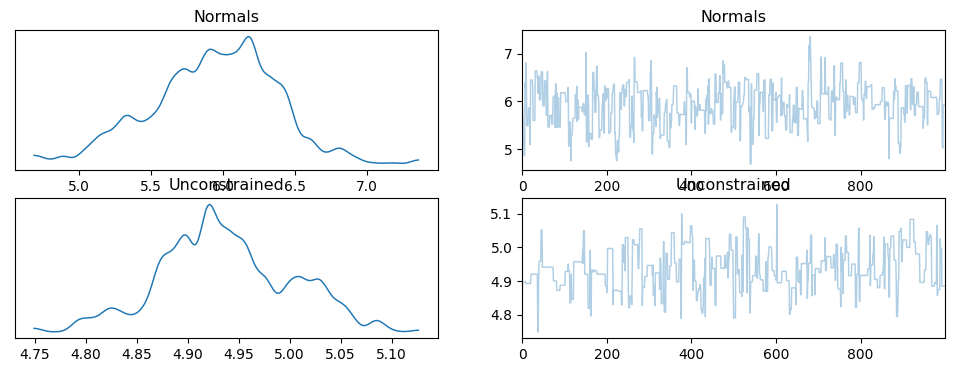

In [144]:
az.plot_trace(post_data_init)


array([<AxesSubplot: title={'center': 'Normals\n0, 0'}>,
       <AxesSubplot: title={'center': 'Unconstrained\n0, 0'}>],
      dtype=object)

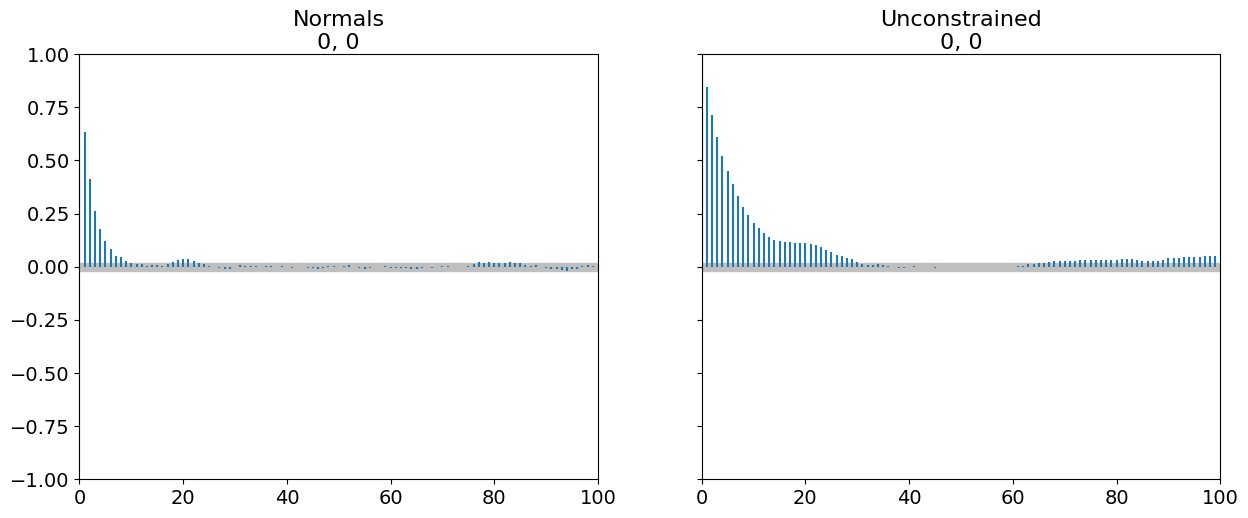

In [141]:
az.plot_autocorr(post_data_init)